In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [2]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

### Load Dataset

In [3]:
# download dataset
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dakshanatharindu
Your Kaggle Key: ··········


100%|██████████| 217M/217M [00:02<00:00, 107MB/s]


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [5]:
train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [7]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


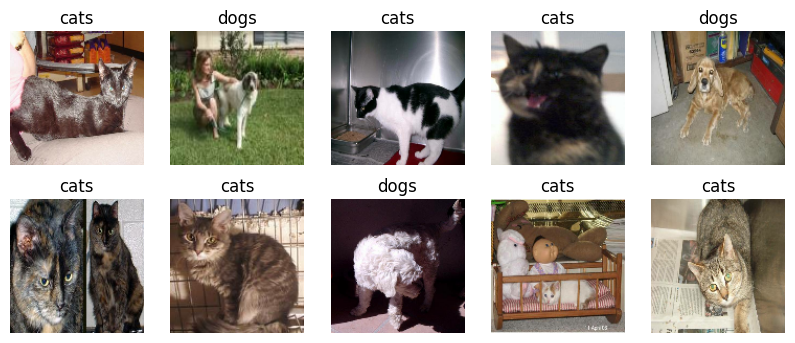

In [8]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

### Scaling Images

In [9]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [10]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

### Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

### Model Building

In [12]:
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Model Training

In [15]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/20
225/225 [==============================] - 18s 46ms/step - loss: 0.6821 - accuracy: 0.5804 - val_loss: 0.6963 - val_accuracy: 0.4988
Epoch 2/20
225/225 [==============================] - 10s 44ms/step - loss: 0.6492 - accuracy: 0.6178 - val_loss: 0.6092 - val_accuracy: 0.6612
Epoch 3/20
225/225 [==============================] - 10s 45ms/step - loss: 0.6265 - accuracy: 0.6481 - val_loss: 0.6618 - val_accuracy: 0.6037
Epoch 4/20
225/225 [==============================] - 10s 42ms/step - loss: 0.6083 - accuracy: 0.6671 - val_loss: 0.6002 - val_accuracy: 0.6712
Epoch 5/20
225/225 [==============================] - 11s 46ms/step - loss: 0.5915 - accuracy: 0.6793 - val_loss: 1.0173 - val_accuracy: 0.5275
Epoch 6/20
225/225 [==============================] - 12s 54ms/step - loss: 0.5797 - accuracy: 0.6881 - val_loss: 0.6063 - val_accuracy: 0.6600
Epoch 7/20
225/225 [==============================] - 11s 46ms/step - loss: 0.5741 - accuracy: 0.6958 - val_loss: 0.6017 - val_accuracy:

In [16]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 228.975 seconds


### Performance Analysis

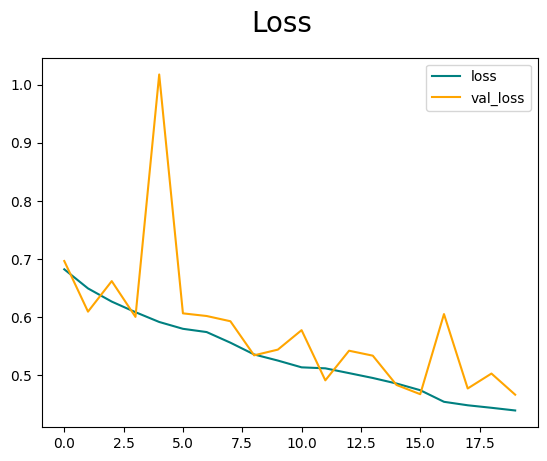

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

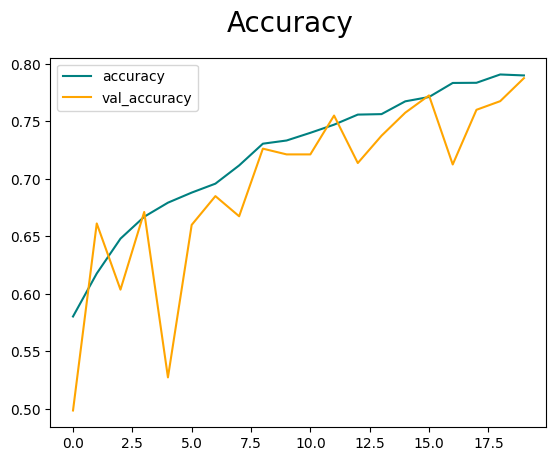

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

### Model Evaluation

In [19]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [20]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 268ms/step


In [21]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.74608696>

In [22]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.858>

In [23]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.783>

### Test

In [24]:
!pip install opencv-python -q

In [25]:
import cv2

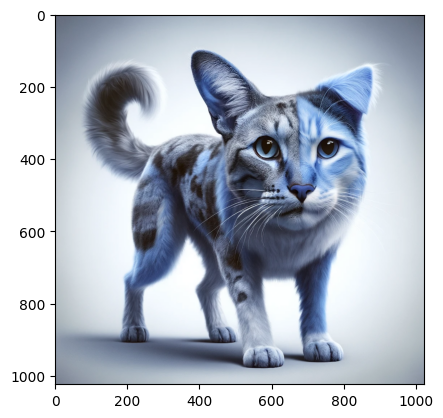

In [50]:
img = cv2.imread('/content/dddog.png')
plt.imshow(img)
plt.show()

In [43]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [44]:
scaled_image.shape

TensorShape([128, 128, 3])

In [45]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [46]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 17ms/step


In [47]:
yhat

array([[0.92023003]], dtype=float32)

In [48]:
class_names

['cats', 'dogs']

In [49]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

dogs


In [51]:
# prompt: Write a code for export the model

model.save('dog_cat_classifier.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [1]:
# prompt: Write python code for make visual application use with the trained model

import streamlit as st
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

st.title('Dog or Cat Classifier')

model = tf.keras.models.load_model('dog_cat_classifier.h5')

class_names = ['Cat', 'Dog']

def predict(image):
    img = cv2.imread(image)
    resized_image = tf.image.resize(img, (128, 128))
    scaled_image = resized_image/255
    yhat = model.predict(np.expand_dims(scaled_image, 0))
    return yhat

def main():
    st.sidebar.title('Upload an Image')
    image = st.sidebar.file_uploader('Upload Images', type=['jpg', 'png'])
    if image is not None:
        st.image(image)
        yhat = predict(image)
        st.write(f'The image is a {class_names[np.argmax(yhat)]}')

if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'streamlit'

In [61]:
# prompt: exportthe model as joblib

from joblib import dump, load
dump(model, 'dog_cat_classifier.joblib')


['dog_cat_classifier.joblib']